In [26]:
import requests
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
from matplotlib import ticker
plt.rcParams['font.family'] = 'Arial Unicode MS'

In [2]:
# Webscrapping Example
"""
# 將json改為csv

url = 'https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=20240124&type=ALLBUT0999&_=1649743235999'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/111.25 (KHTML, like Gecko) Chrome/99.0.2345.81 Safari/123.36'}
    # BUT0999&_=1649743235999 不會抓到Option的資料
res = requests.get(url,headers=headers)

# 去除指數價格
lines = [l for l in res.text.split('\n') if len(l.split(',"'))>=10]
# 將list轉為txt方便用csv讀取
df = pd.read_csv(io.StringIO(','.join(lines)))
# 將不必要的符號去除
df = df.applymap(lambda s:(str(s).replace('=','').replace(',','').replace('"',''))).set_index('證券代號')
# 將數字轉為數值型態
df = df.applymap(lambda s:pd.to_numeric(str(s),errors='coerce')).dropna(how='all',axis=1)
df
"""

'\n# 將json改為csv\n\nurl = \'https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=20240124&type=ALLBUT0999&_=1649743235999\'\nheaders = {\'User-Agent\': \'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/111.25 (KHTML, like Gecko) Chrome/99.0.2345.81 Safari/123.36\'}\n    # BUT0999&_=1649743235999 不會抓到Option的資料\nres = requests.get(url,headers=headers)\n\n# 去除指數價格\nlines = [l for l in res.text.split(\'\n\') if len(l.split(\',"\'))>=10]\n# 將list轉為txt方便用csv讀取\ndf = pd.read_csv(io.StringIO(\',\'.join(lines)))\n# 將不必要的符號去除\ndf = df.applymap(lambda s:(str(s).replace(\'=\',\'\').replace(\',\',\'\').replace(\'"\',\'\'))).set_index(\'證券代號\')\n# 將數字轉為數值型態\ndf = df.applymap(lambda s:pd.to_numeric(str(s),errors=\'coerce\')).dropna(how=\'all\',axis=1)\ndf\n'

In [3]:
# 讀取request response
"""
if res.status_code == 200:
    text_content = res.text
    print(text_content)
else:
    print(f"Error: {res.status_code}")
"""

'\nif res.status_code == 200:\n    text_content = res.text\n    print(text_content)\nelse:\n    print(f"Error: {res.status_code}")\n'

### Webscraping one day stock data

In [4]:
"""
datestr = '20240124'

# 下載股價
r = requests.get('https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + datestr + '&type=ALLBUT0999&_=1649743235999')

# 整理資料，變成表格
df = pd.read_csv(io.StringIO(r.text.replace("=", "")), header=["證券代號" in l for l in r.text.split("\n")].index(True)-1).set_index('證券代號')
    # 把始資料證券代號前“=”去除

# 整理一些字串：
df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce')).dropna(how='all', axis=1)
    # 把第三欄以後的資料型態改成數值，刪掉不必要的欄

df
"""

'\ndatestr = \'20240124\'\n\n# 下載股價\nr = requests.get(\'https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=\' + datestr + \'&type=ALLBUT0999&_=1649743235999\')\n\n# 整理資料，變成表格\ndf = pd.read_csv(io.StringIO(r.text.replace("=", "")), header=["證券代號" in l for l in r.text.split("\n")].index(True)-1).set_index(\'證券代號\')\n    # 把始資料證券代號前“=”去除\n\n# 整理一些字串：\ndf = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors=\'coerce\')).dropna(how=\'all\', axis=1)\n    # 把第三欄以後的資料型態改成數值，刪掉不必要的欄\n\ndf\n'

### Webscrapping multiple days

In [5]:
def daily_price(date):
    datestr = str(date)
    # 下載股價
    r = requests.get('https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + datestr + '&type=ALLBUT0999&_=1649743235999')

    # 整理資料，變成表格
    df = pd.read_csv(io.StringIO(r.text.replace("=", "")), header=["證券代號" in l for l in r.text.split("\n")].index(True)-1).set_index('證券代號')
        # 把始資料證券代號前“=”去除

    # 整理一些字串：
    df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", ""), errors='coerce')).dropna(how='all', axis=1)
        # 把第三欄以後的資料型態改成數值，刪掉不必要的欄

    return df

In [6]:
start_date = '2024-01-01'
end_date = '2024-01-31'
dates = pd.date_range(start=start_date, end=end_date).tolist()
formatted_dates = [date.strftime('%Y%m%d') for date in dates]
print(formatted_dates)

['20240101', '20240102', '20240103', '20240104', '20240105', '20240106', '20240107', '20240108', '20240109', '20240110', '20240111', '20240112', '20240113', '20240114', '20240115', '20240116', '20240117', '20240118', '20240119', '20240120', '20240121', '20240122', '20240123', '20240124', '20240125', '20240126', '20240127', '20240128', '20240129', '20240130', '20240131']


In [7]:
data = {}
fail_dates = []
for i in tqdm(formatted_dates):
    fail_count = 0
    max_fail = 3
    try:
        df = daily_price(i)
        data[i] = df
    except:
        fail_dates.append(i)
        fail_count += 1
        if fail_count == max_fail:
            raise

    time.sleep(2.6)

# Known problem, if fetched data on weekends or holidays with no trade data, it will return error.
# In some dates, some columns contain different type of data and will report warning

  0%|          | 0/31 [00:00<?, ?it/s]

In [8]:
fail_dates

['20240101',
 '20240106',
 '20240107',
 '20240113',
 '20240114',
 '20240120',
 '20240121',
 '20240127',
 '20240128']

In [9]:
data

{'20240102':           成交股數   成交筆數       成交金額     開盤價     最高價     最低價     收盤價  漲跌價差  \
 證券代號                                                                     
 0050   6283610  10013  848793104  135.60  135.95  134.65  134.90  0.55   
 0051     64969    313    4773744   73.65   73.80   73.20   73.45  0.20   
 0052    459461    487   59030788  129.40  129.40  127.95  128.45  0.95   
 0053     12197     21     868663   71.60   71.60   71.00   71.25  0.40   
 0055    299293    242    7218369   24.12   24.17   24.06   24.13  0.01   
 ...        ...    ...        ...     ...     ...     ...     ...   ...   
 9944    132686    150    2685810   20.20   20.30   20.20   20.25  0.05   
 9945  15196853   8077  590772910   37.95   39.35   37.80   39.25  1.50   
 9946    470703    251    9771854   20.40   21.00   20.35   21.00  0.60   
 9955    173540    222    4229761   24.65   24.65   24.20   24.30  0.10   
 9958   5235083   3954  925009116  176.50  180.50  173.50  173.50  1.00   
 
       最後揭示

### Save data to csv or Excel

In [10]:
# Save multiple DataFrames to Excel in different sheets
with pd.ExcelWriter('TW_Stock_STprice.xlsx') as writer:
    for sheet_name, df in tqdm(data.items()):
        df.to_excel(writer, sheet_name=sheet_name)

  0%|          | 0/22 [00:00<?, ?it/s]

#### Read data from csv (1 day data) or Excel(Multiple days data)

In [11]:
data_readexcel = pd.read_excel('/Users/hoover/Documents/Github/TW Stock/TW_Stock_STprice.xlsx',index_col=0 ,sheet_name=None)
data = data_readexcel
data

{'20240102':           成交股數   成交筆數       成交金額     開盤價     最高價     最低價     收盤價  漲跌價差  \
 證券代號                                                                     
 0050   6283610  10013  848793104  135.60  135.95  134.65  134.90  0.55   
 0051     64969    313    4773744   73.65   73.80   73.20   73.45  0.20   
 0052    459461    487   59030788  129.40  129.40  127.95  128.45  0.95   
 0053     12197     21     868663   71.60   71.60   71.00   71.25  0.40   
 0055    299293    242    7218369   24.12   24.17   24.06   24.13  0.01   
 ...        ...    ...        ...     ...     ...     ...     ...   ...   
 9944    132686    150    2685810   20.20   20.30   20.20   20.25  0.05   
 9945  15196853   8077  590772910   37.95   39.35   37.80   39.25  1.50   
 9946    470703    251    9771854   20.40   21.00   20.35   21.00  0.60   
 9955    173540    222    4229761   24.65   24.65   24.20   24.30  0.10   
 9958   5235083   3954  925009116  176.50  180.50  173.50  173.50  1.00   
 
       最後揭示

### Time series for selected variables

In [12]:
close = pd.DataFrame({a:b['收盤價'] for a,b in data.items()}).transpose()
#close.index = pd.to_datetime(close.index)
display(close.head(3), close.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,134.90,73.45,128.45,71.25,24.13,37.17,99.25,16.15,65.90,88.85,...,29.9,188.5,49.45,134.5,90.2,20.25,39.25,21.00,24.3,173.5
20240103,132.55,72.50,125.90,70.10,23.92,36.68,97.70,16.07,64.75,87.75,...,29.7,187.0,49.55,133.0,90.2,20.20,38.70,20.90,24.3,177.5
20240104,132.50,72.60,125.70,69.65,23.96,36.59,97.50,15.92,64.75,87.60,...,29.7,186.0,49.75,132.5,90.4,20.20,38.55,21.35,24.0,180.0


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,136.50,73.35,135.40,73.70,23.61,36.28,102.45,15.92,65.7,90.3,...,29.20,177.5,50.0,128.5,89.9,20.40,36.35,22.00,23.5,225.0
20240130,136.15,73.45,135.45,73.85,23.51,36.36,102.40,15.59,65.8,90.4,...,29.15,175.5,50.1,128.5,89.6,20.35,35.90,21.75,23.3,222.5
20240131,134.35,73.20,133.20,73.10,23.50,36.20,101.30,15.48,65.0,89.4,...,29.00,174.5,50.1,128.5,89.9,20.10,35.75,21.75,23.7,219.0


In [13]:
open = pd.DataFrame({a:b['開盤價'] for a,b in data.items()}).transpose()
#open.index = pd.to_datetime(open.index)
display(open.head(3), open.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,135.60,73.65,129.40,71.60,24.12,37.45,100.0,16.33,65.55,89.40,...,29.90,186.0,49.35,134.5,90.4,20.20,37.95,20.40,24.65,176.5
20240103,133.70,73.20,127.25,70.35,24.07,37.00,98.1,16.13,65.60,88.25,...,29.90,187.5,49.40,134.0,90.1,20.25,39.10,20.85,24.30,174.0
20240104,132.55,72.00,125.85,70.20,23.95,36.65,97.4,16.07,64.90,87.40,...,29.65,188.0,49.50,133.0,90.5,20.20,38.60,20.90,24.10,176.0


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,135.65,72.55,134.80,73.40,23.60,36.07,102.45,16.00,65.50,89.8,...,29.0,177.0,50.0,128.5,89.0,20.35,36.3,21.25,23.4,219.0
20240130,136.35,73.40,135.40,74.10,23.66,36.32,102.25,15.86,65.85,90.2,...,29.2,178.0,50.0,128.5,89.6,20.35,36.8,22.45,23.6,226.0
20240131,135.25,73.40,134.45,73.05,23.50,36.33,101.50,15.49,65.00,89.5,...,29.1,175.0,50.1,128.5,89.6,20.30,35.9,21.50,23.4,224.5


In [14]:
n_share_traded = pd.DataFrame({a:b['成交股數'] for a,b in data.items()}).transpose()
#n_share_traded.index = pd.to_datetime(n_share_traded.index)
display(n_share_traded.head(3), n_share_traded.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,6283610.0,64969.0,459461.0,12197.0,299293.0,35537298.0,3001.0,289164.0,2981.0,7488.0,...,132903.0,740862.0,6000.0,122869.0,68461.0,132686.0,15196853.0,470703.0,173540.0,5235083.0
20240103,14783894.0,94184.0,537274.0,5931.0,387858.0,87773322.0,9991.0,182829.0,9945.0,30635.0,...,163954.0,978693.0,22000.0,194596.0,95998.0,125198.0,8656124.0,246540.0,258424.0,3126043.0
20240104,4838660.0,903102.0,182889.0,17027.0,99125.0,35761413.0,12190.0,327837.0,13528.0,4375.0,...,84907.0,520039.0,26199.0,168687.0,75936.0,88999.0,4599758.0,576543.0,272043.0,4318381.0


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,27291722.0,58317.0,317921.0,19707.0,133018.0,22427662.0,5069.0,651436.0,23309.0,19269.0,...,67604.0,356907.0,77291.0,84754.0,76362.0,89097.0,1827000.0,969902.0,108589.0,6736369.0
20240130,9944399.0,66736.0,206518.0,14018.0,283727.0,24343773.0,7075.0,652395.0,8688.0,10599.0,...,73398.0,589914.0,48613.0,76121.0,86969.0,73562.0,3748992.0,328086.0,102873.0,5110982.0
20240131,7320760.0,27588.0,299727.0,5063.0,122577.0,15693607.0,2044.0,548406.0,3471.0,3313.0,...,91120.0,796197.0,10801.0,112007.0,79539.0,115690.0,1816851.0,225917.0,259862.0,3997090.0


In [15]:
n_transaction = pd.DataFrame({a:b['成交筆數'] for a,b in data.items()}).transpose()
#n_transaction.index = pd.to_datetime(n_transaction.index)
display(n_transaction.head(3), n_transaction.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,10013.0,313.0,487.0,21.0,242.0,25745.0,72.0,196.0,71.0,28.0,...,119.0,1454.0,6.0,168.0,116.0,150.0,8077.0,251.0,222.0,3954.0
20240103,25258.0,390.0,883.0,69.0,367.0,59289.0,74.0,154.0,94.0,77.0,...,142.0,1531.0,17.0,246.0,111.0,306.0,9656.0,162.0,179.0,2319.0
20240104,7094.0,232.0,304.0,73.0,230.0,21760.0,65.0,244.0,74.0,88.0,...,84.0,1020.0,19.0,209.0,97.0,133.0,4828.0,388.0,237.0,4235.0


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,14077.0,216.0,642.0,88.0,352.0,11481.0,77.0,307.0,83.0,89.0,...,132.0,938.0,28.0,140.0,163.0,141.0,1997.0,531.0,89.0,8434.0
20240130,8051.0,208.0,438.0,86.0,313.0,10456.0,101.0,365.0,88.0,94.0,...,288.0,2019.0,15.0,129.0,96.0,134.0,2045.0,262.0,110.0,11843.0
20240131,11931.0,175.0,578.0,15.0,222.0,11066.0,7.0,282.0,75.0,79.0,...,135.0,2056.0,19.0,179.0,120.0,213.0,1216.0,236.0,259.0,15401.0


In [16]:
turnover = pd.DataFrame({a:b['成交金額'] for a,b in data.items()}).transpose()
#turnover.index = pd.to_datetime(turnover.index)
display(turnover.head(3), turnover.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,8.487931e+08,4773744.0,59030788.0,868663.0,7218369.0,1.321112e+09,297722.0,4684665.0,195472.0,667872.0,...,3971125.0,138732744.0,296350.0,16470226.0,6178524.0,2685810.0,590772910.0,9771854.0,4229761.0,925009116.0
20240103,1.963127e+09,6839329.0,67755677.0,416224.0,9286713.0,3.224668e+09,977467.0,2941542.0,646703.0,2682407.0,...,4868943.0,182677226.0,1088250.0,25972094.0,8673446.0,2538954.0,335683686.0,5151141.0,6259087.0,549723692.0
20240104,6.412029e+08,65323048.0,22984528.0,1188387.0,2374083.0,1.309252e+09,1187778.0,5230958.0,876366.0,382417.0,...,2523377.0,97185674.0,1301410.0,22373279.0,6869163.0,1800300.0,177533499.0,12194665.0,6545174.0,773080808.0


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,3.720069e+09,4263253.0,42885469.0,1450237.0,3144561.0,812631564.0,517882.0,10359573.0,1529575.0,1737059.0,...,1969370.0,63456325.0,3864550.0,10921767.0,6853193.0,1814073.0,66378953.0,21090603.0,2536620.0,1.513365e+09
20240130,1.356292e+09,4896454.0,28015340.0,1033616.0,6683716.0,884730598.0,722078.0,10225863.0,570283.0,955859.0,...,2135444.0,103969928.0,2430674.0,9817071.0,7795626.0,1496449.0,135350314.0,7176444.0,2396329.0,1.149486e+09
20240131,9.859612e+08,2019892.0,40090970.0,369907.0,2876301.0,568023215.0,207228.0,8471745.0,225645.0,296075.0,...,2647717.0,138979214.0,540857.0,14366041.0,7124021.0,2343602.0,65040060.0,4913652.0,6143043.0,8.816657e+08


In [17]:
high = pd.DataFrame({a:b['最高價'] for a,b in data.items()}).transpose()
#high.index = pd.to_datetime(high.index)
display(high.head(3), high.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,135.95,73.8,129.40,71.60,24.17,37.50,100.00,16.33,65.9,89.50,...,30.00,188.5,49.50,135.0,90.4,20.30,39.35,21.00,24.65,180.5
20240103,133.90,73.2,127.25,70.35,24.07,37.00,98.10,16.13,65.6,88.25,...,29.90,187.5,49.55,134.5,90.6,20.35,39.15,21.10,24.35,177.5
20240104,132.75,72.8,126.00,70.20,23.98,36.75,97.65,16.13,64.9,87.60,...,29.95,188.0,49.75,133.5,90.8,20.30,38.85,21.45,24.20,180.5


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,136.65,73.35,135.40,73.9,23.68,36.31,102.45,16.05,65.70,90.3,...,29.25,178.5,50.0,129.5,90.0,20.4,36.50,22.00,23.6,228.0
20240130,136.65,73.75,136.00,74.1,23.67,36.41,102.65,15.87,65.85,90.4,...,29.20,178.0,50.1,129.5,89.9,20.4,36.80,22.45,23.6,229.5
20240131,135.30,73.45,134.45,73.1,23.50,36.33,101.50,15.59,65.00,89.5,...,29.10,175.0,50.1,129.0,89.9,20.4,35.95,21.85,23.9,225.5


In [18]:
low = pd.DataFrame({a:b['最低價'] for a,b in data.items()}).transpose()
#low.index = pd.to_datetime(low.index)
display(low.head(3), low.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,134.65,73.20,127.95,71.00,24.06,37.00,99.25,16.08,65.55,88.85,...,29.75,185.0,49.35,133.5,90.0,20.2,37.80,20.35,24.2,173.5
20240103,132.30,72.35,125.60,70.10,23.90,36.59,97.70,16.04,64.70,87.45,...,29.55,185.5,49.40,133.0,90.1,20.2,38.55,20.65,24.1,172.0
20240104,132.30,72.00,125.35,69.65,23.88,36.55,97.40,15.87,64.75,87.40,...,29.65,186.0,49.50,132.0,90.2,20.2,38.45,20.80,24.0,175.5


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,135.60,72.55,134.6,73.40,23.58,36.02,102.45,15.80,65.5,89.8,...,29.00,177.0,50.0,128.5,89.0,20.3,36.15,21.25,23.05,216.5
20240130,136.05,73.20,135.1,73.65,23.50,36.25,102.10,15.56,65.5,90.2,...,29.05,175.5,50.0,128.5,89.4,20.3,35.85,21.50,23.20,222.0
20240131,134.35,73.05,133.2,73.05,23.38,36.15,101.30,15.38,65.0,89.4,...,29.00,174.0,50.1,127.5,89.2,20.1,35.60,21.50,23.40,218.0


In [19]:
PE_ratio = pd.DataFrame({a:b['本益比'] for a,b in data.items()}).transpose()
#PE_ratio.index = pd.to_datetime(PE_ratio.index)
display(PE_ratio.head(3), PE_ratio.tail(3))

證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.91,18.57,0.0,11.63,14.05,6.06,18.87,123.53,0.0,90.84
20240103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.81,18.42,0.0,11.51,14.05,6.05,18.61,122.94,0.0,92.93
20240104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.81,18.33,0.0,11.46,14.08,6.05,18.53,125.59,0.0,94.24


證券代號,0050,0051,0052,0053,0055,0056,0057,0061,006203,006204,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
20240129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.58,17.49,0.0,11.12,14.00,6.11,17.48,129.41,0.0,117.80
20240130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.56,17.29,0.0,11.12,13.96,6.09,17.26,127.94,0.0,116.49
20240131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.49,17.19,0.0,11.12,14.00,6.02,17.19,127.94,0.0,114.66


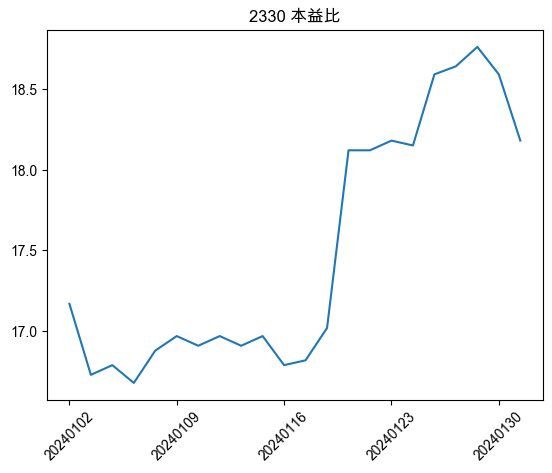

In [20]:
PE_ratio['2330'].plot()
plt.title("2330 本益比")
plt.xticks(rotation=45)
plt.show()

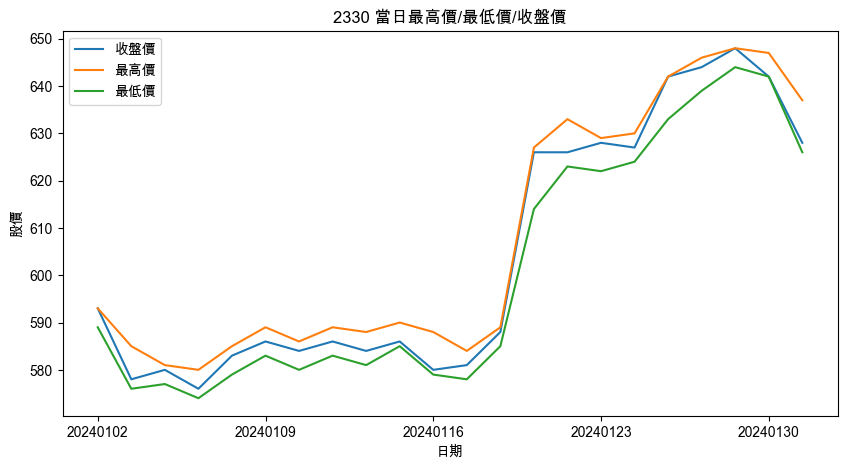

In [21]:
close['2330'].plot(figsize=(10,5))
high['2330'].plot()
low['2330'].plot()
plt.title("2330 當日最高價/最低價/收盤價")
plt.legend(['收盤價','最高價','最低價'])
plt.xlabel('日期')
plt.ylabel('股價')
plt.xticks()
plt.show()

### 個股逐日價格走勢圖

In [22]:
from matplotlib.ticker import AutoMinorLocator

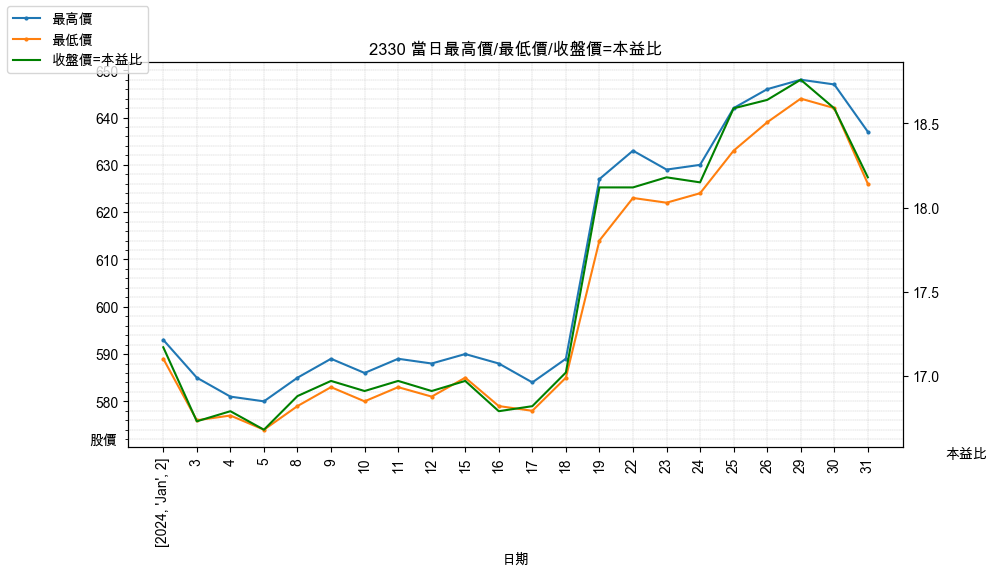

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(high['2330'], marker='o', markersize=2)
ax.plot(low['2330'], marker='o', markersize=2)
ax.set_xlabel('日期')
ax.set_ylabel('股價', rotation=0, loc='bottom')
ax.set_title('2330 當日最高價/最低價/收盤價=本益比')

ax2 = ax.twinx() 
ax2.plot(PE_ratio['2330'], color='green')   # PE_ratio is same as close
ax2.set_ylabel("本益比", rotation=0, loc='bottom')

fig.legend(['最高價','最低價',"收盤價=本益比"], loc=2)

def custom_date_format(date):
    last_month = None
    last_year = None
    date_list = []
    for i in date.index:
        date_obj = pd.to_datetime(i)

        # Check if it's the first day of the year
        if last_year != date_obj.year:
            #print(f"Year: {date_obj.year}, Month: {date_obj.strftime('%b')}, Day: {date_obj.day}")
            date_list.append([date_obj.year, date_obj.strftime('%b'), date_obj.day])

        # Check if it's the first day of the month
        elif last_month != date_obj.month:
            #print(f"Month: {date_obj.strftime('%b')}, Day: {date_obj.day}")
            date_list.append([date_obj.strftime('%b'), date_obj.day])

        # For other dates, return the day
        else:
            #print(f"Day: {date_obj.day}")
            date_list.append(date_obj.day)

        last_year = date_obj.year
        last_month = date_obj.month
    
    return  date_list
    

ax.set_xticks(high.index, [i for i in custom_date_format(high['2330'])], rotation=90)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which='both', linestyle='--', linewidth=0.25)

"""
# Function to format tick labels based on date
def custom_date_format(date):
    day = date.strftime('%d')
    month = date.strftime('%b')
    year = date.strftime('%Y')
    
    if date.day == 1 and date.month == 1:
        return f'{day}\n{month}\n{year}'
    elif date.day == 1:
        return f'{day}\n{month}'
    else:
        return f'{day}'
    
ax.set_xticks(high.index, [custom_date_format(date) for date in high.index])
"""
# use datetime to reference the dates
plt.show()

### 個股逐日交易量

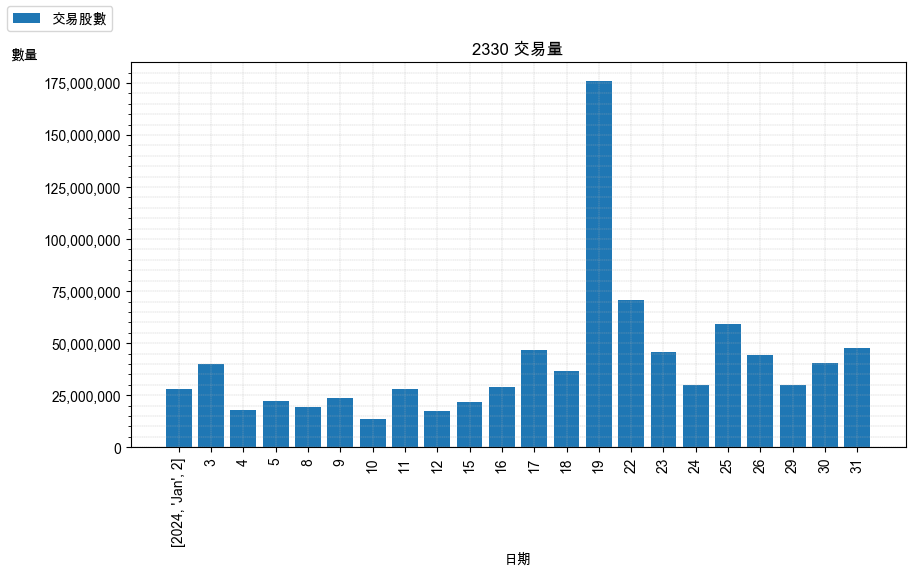

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(n_share_traded['2330'].index, n_share_traded['2330'].values)
ax.set_xlabel('日期')
ax.set_ylabel('數量', rotation=0, loc='top')
ax.set_title('2330 交易量')
fig.legend(['交易股數'], loc=2);

def custom_date_format(date):
    last_month = None
    last_year = None
    date_list = []
    for i in date.index:
        date_obj = pd.to_datetime(i)

        # Check if it's the first day of the year
        if last_year != date_obj.year:
            #print(f"Year: {date_obj.year}, Month: {date_obj.strftime('%b')}, Day: {date_obj.day}")
            date_list.append([date_obj.year, date_obj.strftime('%b'), date_obj.day])

        # Check if it's the first day of the month
        elif last_month != date_obj.month:
            #print(f"Month: {date_obj.strftime('%b')}, Day: {date_obj.day}")
            date_list.append([date_obj.strftime('%b'), date_obj.day])

        # For other dates, return the day
        else:
            #print(f"Day: {date_obj.day}")
            date_list.append(date_obj.day)

        last_year = date_obj.year
        last_month = date_obj.month
    
    return  date_list
    

ax.set_xticks(high.index, [i for i in custom_date_format(high['2330'])], rotation=90)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(True, which='both', linestyle='--', linewidth=0.25)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.show()